## Import and runtime info

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import warnings
import kagglehub
from dotenv import load_dotenv
warnings.filterwarnings("ignore")

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
    BATCH_SIZE = 32
else:
    print("Failed to detect a GPU.")
    BATCH_SIZE = 64
    
print('tensorflow version: ' + tf.__version__)

np.random.seed(69)
tf.random.set_seed(69)

load_dotenv()

os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")

2024-12-12 17:59:25.399239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 17:59:25.412805: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 17:59:25.417026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 17:59:25.427205: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
tensorflow version: 2.17.0


I0000 00:00:1734022767.321920   84371 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734022767.349602   84371 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734022767.349685   84371 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


## load data set

In [2]:
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")
cell_images_path = os.path.join(path, "cell_images")

print("Path to dataset files:", path)
print("Contents of cell_images folder:", os.listdir(cell_images_path))

Path to dataset files: /home/mba/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1
Contents of cell_images folder: ['Parasitized', 'Uninfected', 'cell_images']


## preview

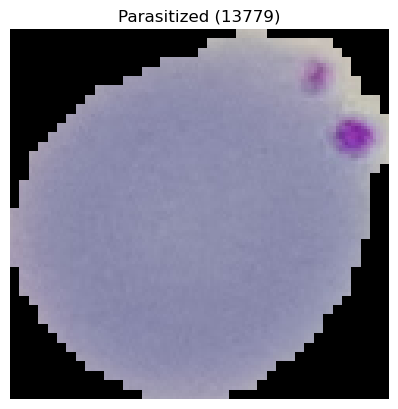

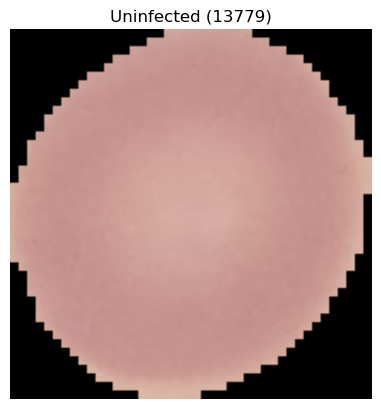

In [3]:
parasitized_images = glob.glob(os.path.join(cell_images_path, "Parasitized", "*.png"))
uninfected_images = glob.glob(os.path.join(cell_images_path, "Uninfected", "*.png"))

image = Image.open(parasitized_images[0])
plt.figure()
plt.imshow(image)
plt.axis("off")
plt.title("Parasitized (" + str(len(parasitized_images)) + ")")
plt.show()

image = Image.open(uninfected_images[0])
plt.figure()
plt.imshow(image)
plt.axis("off")
plt.title("Uninfected (" + str(len(uninfected_images)) + ")")
plt.show() 

## Preprocessing

In [4]:
images = []
labels = []

target_width = 128
target_height = 128

for img_path in uninfected_images:
    img = load_img(img_path, target_size=(target_width, target_height))  # Resize to (128x128)
    images.append(img_to_array(img))
    labels.append(0)  # Uninfected 

# Load images and assign labels
for img_path in parasitized_images:
    img = load_img(img_path, target_size=(target_width, target_height))  # Resize to (128x128)
    images.append(img_to_array(img))
    labels.append(1)  # Parasitized

# Convert to numpy arrays and normalize pixel values
images = np.array(images, dtype="float32") / 255.0
labels = np.array(labels)

# use 30% of full dataset as validation and test data
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
# then: use 50% for validation and 50% for test  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

print(f"Training data: {len(X_train)}")
print(f"Validation data: {len(X_val)}")
print(f"Testing data: {len(X_test)}")

Images shape: (27558, 128, 128, 3)
Labels shape: (27558,)
Training data: 19290
Validation data: 4134
Testing data: 4134


## Model Architecture

In [5]:
warnings.filterwarnings('ignore')

from keras import layers, models

model = models.Sequential([
    #Input layer   
    layers.Input(shape=(128, 128, 3)),  # Explicit Input layer

    # data augmentation
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),

    # neural network   
    
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.relu, padding="SAME"),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=tf.nn.relu, padding="SAME"),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation=tf.nn.relu, padding="SAME"),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(filters=256, kernel_size=(9,9), activation=tf.nn.relu, padding="SAME"),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Flatten(),  # Flatten the feature maps

    # Use a dense (fully connected) layer to perform a classification based on features
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    
    # Output layer
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.summary()     

I0000 00:00:1734022785.320814   84371 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734022785.320927   84371 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734022785.320982   84371 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734022785.483750   84371 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734022785.483846   84371 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-12

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,942,529 (26.48 MB)

 Trainable params: 6,942,529 (26.48 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
LEARNING_RATE_PARAM = 0.001

# Learning Rate scheduler
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)

# Optimizers
_rms = keras.optimizers.RMSprop(learning_rate=lr_schedule)
_sgd = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PARAM, momentum=0.9, nesterov=True)
_adam = keras.optimizers.Adam(learning_rate=LEARNING_RATE_PARAM)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

OPTIMIZER_PARAM = _rms
CALLBACKS = [early_stopping]
EPOCH_PARAM = 75


In [7]:
model.compile(
    optimizer=OPTIMIZER_PARAM,
    loss="binary_crossentropy", 
    metrics=['accuracy']
)

print(f"Using batch size: {BATCH_SIZE}")
print(f"Using learning rate: {LEARNING_RATE_PARAM}")
print(f"Using optimizer: {OPTIMIZER_PARAM}")
print(f"Epoch size: {EPOCH_PARAM}")

history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCH_PARAM,
        batch_size=BATCH_SIZE, # 32 - GPU, 64 - CPU
        callbacks=CALLBACKS
    )

Using batch size: 32
Using learning rate: 0.001
Using optimizer: <keras.src.optimizers.rmsprop.RMSprop object at 0x7fc3d41ece60>
Epoch size: 75


2024-12-12 17:59:47.167095: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3792568320 exceeds 10% of free system memory.
2024-12-12 17:59:48.355924: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3792568320 exceeds 10% of free system memory.


Epoch 1/75


2024-12-12 17:59:50.951122: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90600
W0000 00:00:1734022791.003873   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.024732   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.026218   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.030494   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.031902   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.033076   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.034912   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.036362   84591 gpu_

  8/603 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.4587 - loss: 0.7567 

W0000 00:00:1734022791.966880   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.972352   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.974076   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.977306   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.978508   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.980008   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.981606   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.982992   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022791.984286   84591 gp

599/603 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6480 - loss: 0.5767

W0000 00:00:1734022801.269724   84588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.270696   84588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.271551   84588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.272496   84588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.273351   84588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.274104   84588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.275028   84588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.275955   84588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.276957   84588 gp

603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6490 - loss: 0.5756

W0000 00:00:1734022801.681306   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.682750   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.684584   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.685967   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.687224   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.688935   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.690503   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.691845   84591 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022801.693345   84591 gp

603/603 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.6492 - loss: 0.5753 - val_accuracy: 0.9429 - val_loss: 0.1693
Epoch 2/75


W0000 00:00:1734022803.501258   84585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022803.501875   84585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022803.502892   84585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022803.503522   84585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022803.504127   84585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022803.504715   84585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022803.505450   84585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022803.506233   84585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734022803.507322   84585 gp

603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9488 - loss: 0.1711 - val_accuracy: 0.9364 - val_loss: 0.2017
Epoch 3/75
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9511 - loss: 0.1566 - val_accuracy: 0.9405 - val_loss: 0.1856
Epoch 4/75
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9528 - loss: 0.1486 - val_accuracy: 0.9054 - val_loss: 0.2878
Epoch 5/75
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9542 - loss: 0.1441 - val_accuracy: 0.9274 - val_loss: 0.2328
Epoch 6/75
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9540 - loss: 0.1426 - val_accuracy: 0.9390 - val_loss: 0.1862
Epoch 7/75
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9567 - loss: 0.1385 - val_accuracy: 0.9301 - val_loss: 0.2471
Epoch 8/75
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9546 - loss: 0.1425 - val_accuracy: 0.9340 - val_loss: 0.1943
Epoch 9/75
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9576 - loss: 0.1383 - val_accurac

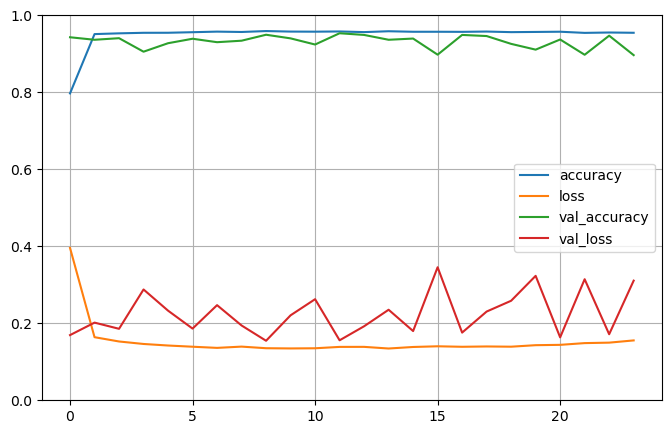

In [8]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
     

In [9]:
model.evaluate(X_test, y_test)

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9439 - loss: 0.1868


[0.16851471364498138, 0.9479922652244568]